# Wave file transformation

In [1]:
import ffmpeg
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io.wavfile import read

In [2]:
#file = '92002__jcveliz__violin-origional.wav'
file = 'heavy_sample.wav'

## Read wave file with ffmpeg

In [3]:
probe = ffmpeg.probe(file)

print(json.dumps(probe, indent=3))

{
   "streams": [
      {
         "index": 0,
         "codec_name": "pcm_s16le",
         "codec_long_name": "PCM signed 16-bit little-endian",
         "codec_type": "audio",
         "codec_time_base": "1/44100",
         "codec_tag_string": "[1][0][0][0]",
         "codec_tag": "0x0001",
         "sample_fmt": "s16",
         "sample_rate": "44100",
         "channels": 2,
         "bits_per_sample": 16,
         "r_frame_rate": "0/0",
         "avg_frame_rate": "0/0",
         "time_base": "1/44100",
         "duration_ts": 441000,
         "duration": "10.000000",
         "bit_rate": "1411200",
         "disposition": {
            "default": 0,
            "dub": 0,
            "original": 0,
            "comment": 0,
            "lyrics": 0,
            "karaoke": 0,
            "forced": 0,
            "hearing_impaired": 0,
            "visual_impaired": 0,
            "clean_effects": 0,
            "attached_pic": 0,
            "timed_thumbnails": 0
         }
      }
  

In [4]:
class SoundError(Exception):
    """ Custom exception for Sound related error. """

    pass

In [5]:
def _to_ffmpeg_time(n):
    """ Format number of seconds to time expected by FFMPEG.
    :param n: Time in seconds to format.
    :returns: Formatted time in FFMPEG format.
    """
    m, s = divmod(n, 60)
    h, m = divmod(m, 60)
    return '%d:%02d:%09.6f' % (h, m, s)

In [6]:
offset=None
duration=None
dtype=np.float32

if 'streams' not in probe:
    raise SoundError("No stream was found with ffprobe")


metadata = next(stream 
                for stream in probe['streams'] 
                if stream['codec_type'] == 'audio')

n_channels = metadata['channels']
sample_rate = metadata['sample_rate']

output_kwargs = {'format': 'f32le', 'ar': sample_rate}
if duration is not None:
    output_kwargs['t'] = _to_ffmpeg_time(duration)
if offset is not None:
    output_kwargs['ss'] = _to_ffmpeg_time(offset)
    
process = (
    ffmpeg
    .input(file)
    .output('pipe:', **output_kwargs)
    .run_async(pipe_stdout=True, pipe_stderr=True))

buffer, _ = process.communicate()
waveform = np.frombuffer(buffer, dtype='<f4')
waveform_reshape = waveform.reshape(-1, n_channels)
if not waveform_reshape.dtype == np.dtype(dtype):
    waveform_reshape = waveform_reshape.astype(dtype)

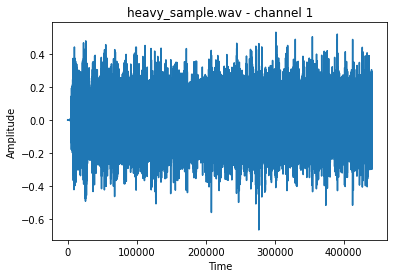

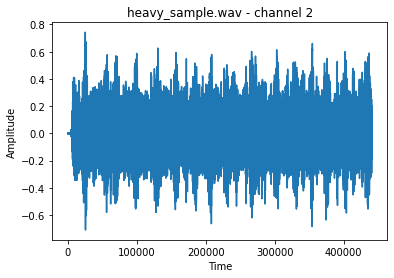

In [25]:
for item in range(waveform_reshape.shape[1]):
    plt.plot(waveform_reshape[:, item])
    # label the axes
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    # set the title  
    plt.title("%s - channel %i" % (file, item+1))
    # display the plot
    plt.show()

## Convert numpy array to wave

In [26]:
wave_transpose = waveform_reshape.transpose()
Audio(data=wave_transpose, rate=int(sample_rate))

## Read wave file with scipy

<ipython-input-27-b59be4630786>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sound_rate, sound_data) = read(file)


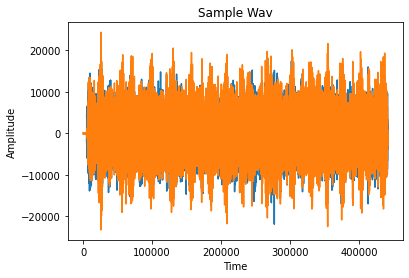

In [27]:
(sound_rate, sound_data) = read(file)

plt.plot(sound_data)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time")
# set the title  
plt.title("Sample Wav")
# display the plot
plt.show()

## Convert numpy to wave

In [28]:
sound_transpose = sound_data.transpose()

Audio(data=sound_transpose, rate=sound_rate)